# LobbyView Package Vignette: Corporate Strategy Analysis
## A Case Study of Microsoft's Lobbying Landscape

This vignette demonstrates how to use the LobbyView Python package to analyze corporate lobbying activities through the lens of Microsoft Corporation. We'll explore how a company might evaluate its past lobbying efforts, identify key relationships with legislators, and understand where resources have been allocated.

The analysis will help answer questions like:

- Which issues have received the most lobbying attention?
- Who are our key legislative contacts?
- How has our lobbying activity changed over time?
- What recent bills are relevant to our interests?

This type of analysis would be valuable for:

- Corporate government relations teams planning future strategy
- Compliance officers reviewing lobbying activities
- Executives making decisions about resource allocation
- Researchers studying corporate political activity

## Setup and Configuration

First, we'll set up our environment and import the necessary packages. The LobbyView package requires an API token which should be stored in a `.env` file for security. We'll be doing our function calls to retrieve data using our initialized `lobbyview = LobbyView(LOBBYVIEW_TOKEN)` object.

In [29]:
import os
import sys
from dotenv import load_dotenv
sys.path.append('../src/lobbyview/')
from LobbyView import LobbyView
from exceptions import InvalidPageNumberError

# Load environment variables and set up LobbyView
load_dotenv('../../.env')

LOBBYVIEW_TOKEN = os.environ.get('LOBBYVIEW_TOKEN', "NO TOKEN FOUND")
lobbyview = LobbyView(LOBBYVIEW_TOKEN)

## Starting the Analysis: Client Identification

The first step in any lobbying analysis is identifying the client (company) of interest. The LobbyView API uses a UUID system for unique identification, so we need to convert from a human-readable company name to its corresponding UUID.

The `clients()` method supports:

- Exact UUID lookup
- Partial name matching
- NAICS code filtering (for identifying firms by industry)
- Industry description search

In this case, we'll search for Microsoft Corporation by name.

In [30]:
CLIENT_NAME = "Microsoft Corporation"
client_info = lobbyview.clients(client_name=CLIENT_NAME)

if not client_info.data:
    print(f"No data found for {CLIENT_NAME}")
    sys.exit(1)

In [31]:
# We need to convert from the human-readable company name to its UUID for subsequent queries.
client_uuid = client_info.data[0]['client_uuid']
print(f"Analyzing lobbying activities for {CLIENT_NAME}")

Analyzing lobbying activities for Microsoft Corporation


## Report Analysis

With our client identified, we can now examine their lobbying reports. These reports provide the foundation for understanding a company's lobbying activities.

The `reports()` method gives us access to:

- Filing dates and quarters
- Amount spent on lobbying
- Whether it's an amendment or original filing
- Self-filing status

We'll analyze the temporal distribution of these reports to understand how Microsoft's lobbying activity has evolved.

In [32]:
# Get reports for this client
client_reports = lobbyview.reports(client_uuid=client_uuid)
print(f"Number of reports found: {len(client_reports.data)}")

# the returned amount is 100 because that is the default limit for the API, though we can modify the "page"
# parameter to get more results from different pages (100 results per page, default returns page 1)

Number of reports found: 100


In [33]:
# Analyze report years and quarters
from collections import Counter

report_years = Counter()
report_quarters = Counter()
for report in client_reports.data:
    report_years[report['report_year']] += 1
    report_quarters[report['report_quarter_code']] += 1

print("\nReports by year:")
for year, count in sorted(report_years.items()):
    print(f"  {year}: {count}")

print("\nReports by quarter:")
for quarter, count in sorted(report_quarters.items()):
    print(f"  Q{quarter}: {count}")


Reports by year:
  2010: 29
  2018: 21
  2019: 50

Reports by quarter:
  Q1: 25
  Q2: 25
  Q3: 27
  Q4: 23


## Issue Analysis

Understanding which issues a company lobbies on is crucial for evaluating their political priorities and resource allocation. The LobbyView API provides detailed issue coding and descriptions.

The `issues()` and `texts()` methods allow us to:

- See what specific issues were lobbied on
- Read detailed descriptions of the lobbying activities
- Track issue frequency over time
- Identify patterns in issue focus

This can help companies:

- Review if lobbying efforts match strategic priorities
- Identify gaps in coverage
- Compare against competitor focus areas

In [34]:
print("\nAnalyzing Microsoft's lobbying issues...")

# not necessary - just to suppress the output of the API call when it finds no matching records
from io import StringIO
old_stderr = sys.stderr
sys.stderr = StringIO()
# below is what we actually need to analyze the issues
# Get all issues from Microsoft's reports
all_issues = []
for report in client_reports.data:
    try:
        # use .issues() to get the issues for a report
        issues = lobbyview.issues(report_uuid=report['report_uuid'])
        all_issues.extend(issues.data)
    except InvalidPageNumberError:
        # Skip reports with no issues
        continue


Analyzing Microsoft's lobbying issues...


In [35]:
if not all_issues:
    print("No lobbying issues found for Microsoft")
else:
    # Count frequency of issue codes
    issue_codes = Counter()
    for issue in all_issues:
        issue_codes[issue['issue_code']] += 1
        
    # Create a dictionary to store issue text descriptions
    issue_text_cache = {}

    print("\nTop issues by frequency:")
    for code, count in issue_codes.most_common(10):
        if code not in issue_text_cache:
            try:
                # Try multiple report UUIDs until we find one with text
                for issue in all_issues:
                    if issue['issue_code'] == code:
                        # use .texts() to get the issue text
                        sample_text = lobbyview.texts(issue_code=code, report_uuid=issue['report_uuid'])
                        if sample_text.data:
                            issue_text_cache[code] = sample_text.data[0]['issue_text']
                            break
                if code not in issue_text_cache:
                    issue_text_cache[code] = "No description available"
            except (InvalidPageNumberError, IndexError):
                issue_text_cache[code] = "No description available"
        
        print(f"  {code}: {count} occurrences")
        print(f"    Sample issue text: {issue_text_cache[code][:100]}...")  # Show first 100 chars


Top issues by frequency:
  TAX: 45 occurrences
    Sample issue text: Tax extenders...
  TEC: 42 occurrences
    Sample issue text: telecommuications reform; online advertising; white spaces; online competitiveness, privacy...
  IMM: 41 occurrences
    Sample issue text: immigration issues...
  CPI: 31 occurrences
    Sample issue text: Competition in the online advertising and software markets, Privacy issues, Cloud computing, China...
  TRD: 19 occurrences
    Sample issue text: International trade issues....
  CPT: 16 occurrences
    Sample issue text: patent legislation...
  HOM: 15 occurrences
    Sample issue text: Cyber security; state fusion centers; voluntary private sector preparedness standards;  The Protecti...
  BUD: 14 occurrences
    Sample issue text: Information technology spending / cloud computing...
  INT: 12 occurrences
    Sample issue text: Warrants and surveillance, ECPA, Cyber Security...
  SCI: 11 occurrences
    Sample issue text: science and technology issu

## Legislative Network Analysis

A critical aspect of lobbying is maintaining relationships with legislators. The `networks()` method helps us understand these connections.

We can analyze:

- Which legislators are most frequently connected to the company
- How many bills these legislators have sponsored
- The strength of various legislative relationships
- Changes in network patterns over time

In [36]:
# Analyze network data
network_data = lobbyview.networks(client_uuid=client_uuid)
print(f"\nNumber of network connections: {len(network_data.data)}")

# the returned amount is 100 because that is the default limit for the API, though we can modify the "page"
# parameter to get more results from different pages (100 results per page, default returns page 1)

legislator_counter = Counter()
for network in network_data.data:
    legislator_counter[network['legislator_id']] += network['n_bills_sponsored']

def get_legislator_name(legislator_id):
    """
    Get the full name of a legislator given their ID.

    Args:
        legislator_id (str): The unique ID of the legislator.

    Returns:
        str: The full name of the legislator if found, otherwise the ID.
    """
    legislator_info = lobbyview.legislators(legislator_id=legislator_id)
    if legislator_info.data:
        return legislator_info.data[0]['legislator_full_name']
    return legislator_id  # Return ID if name not found

print("\nTop 5 legislators by bills sponsored:")
for legislator_id, count in legislator_counter.most_common(5):
    legislator_name = get_legislator_name(legislator_id)
    print(f"  {legislator_name}: {count}")


Number of network connections: 100

Top 5 legislators by bills sponsored:
  Kevin Brady: 81
  Max Baucus: 62
  John Conyers, Jr.: 38
  None: 32
  Richard Burr: 29


## Recent Legislative Activity

Understanding recent legislative activity helps companies stay current and evaluate the effectiveness of their lobbying efforts. We'll focus on bills since 2020 that are connected to Microsoft's network.

The `bills()` method provides:

- Bill status and progress
- Sponsorship information
- Introduction and update dates
- Connection to specific issues

In [37]:
# Analyze recent Microsoft-connected bills
recent_ms_bills = []
for network in network_data.data:
    try:
        # Get bills sponsored by legislators connected to Microsoft since 2020
        legislator_bills = lobbyview.bills(
            legislator_id=network['legislator_id'],
            min_introduced_date="2020-01-01"
        )
        recent_ms_bills.extend(legislator_bills.data)
    except InvalidPageNumberError:
        # Skip legislators with no recent bills
        continue

print(f"\nNumber of Microsoft-connected bills introduced since 2020: {len(recent_ms_bills)}")


Number of Microsoft-connected bills introduced since 2020: 311


In [38]:
bill_sponsors = Counter()
for bill in recent_ms_bills:
    bill_sponsors[bill['legislator_id']] += 1

print("\nTop 5 Microsoft-connected bill sponsors since 2020:")
for legislator_id, count in bill_sponsors.most_common(5):
    legislator_name = get_legislator_name(legislator_id)
    print(f"  {legislator_name}: {count}")


Top 5 Microsoft-connected bill sponsors since 2020:
  John Cornyn: 105
  Roy Blunt: 40
  Marsha Blackburn: 32
  Thomas R. Carper: 25
  Sherrod Brown: 20


## Data Visualization

To make our analysis more accessible to stakeholders, we'll create visualizations of key metrics. These visualizations will help communicate:

- Temporal patterns in lobbying activity
- Key legislative relationships
- Issue focus areas
- Recent legislative activity

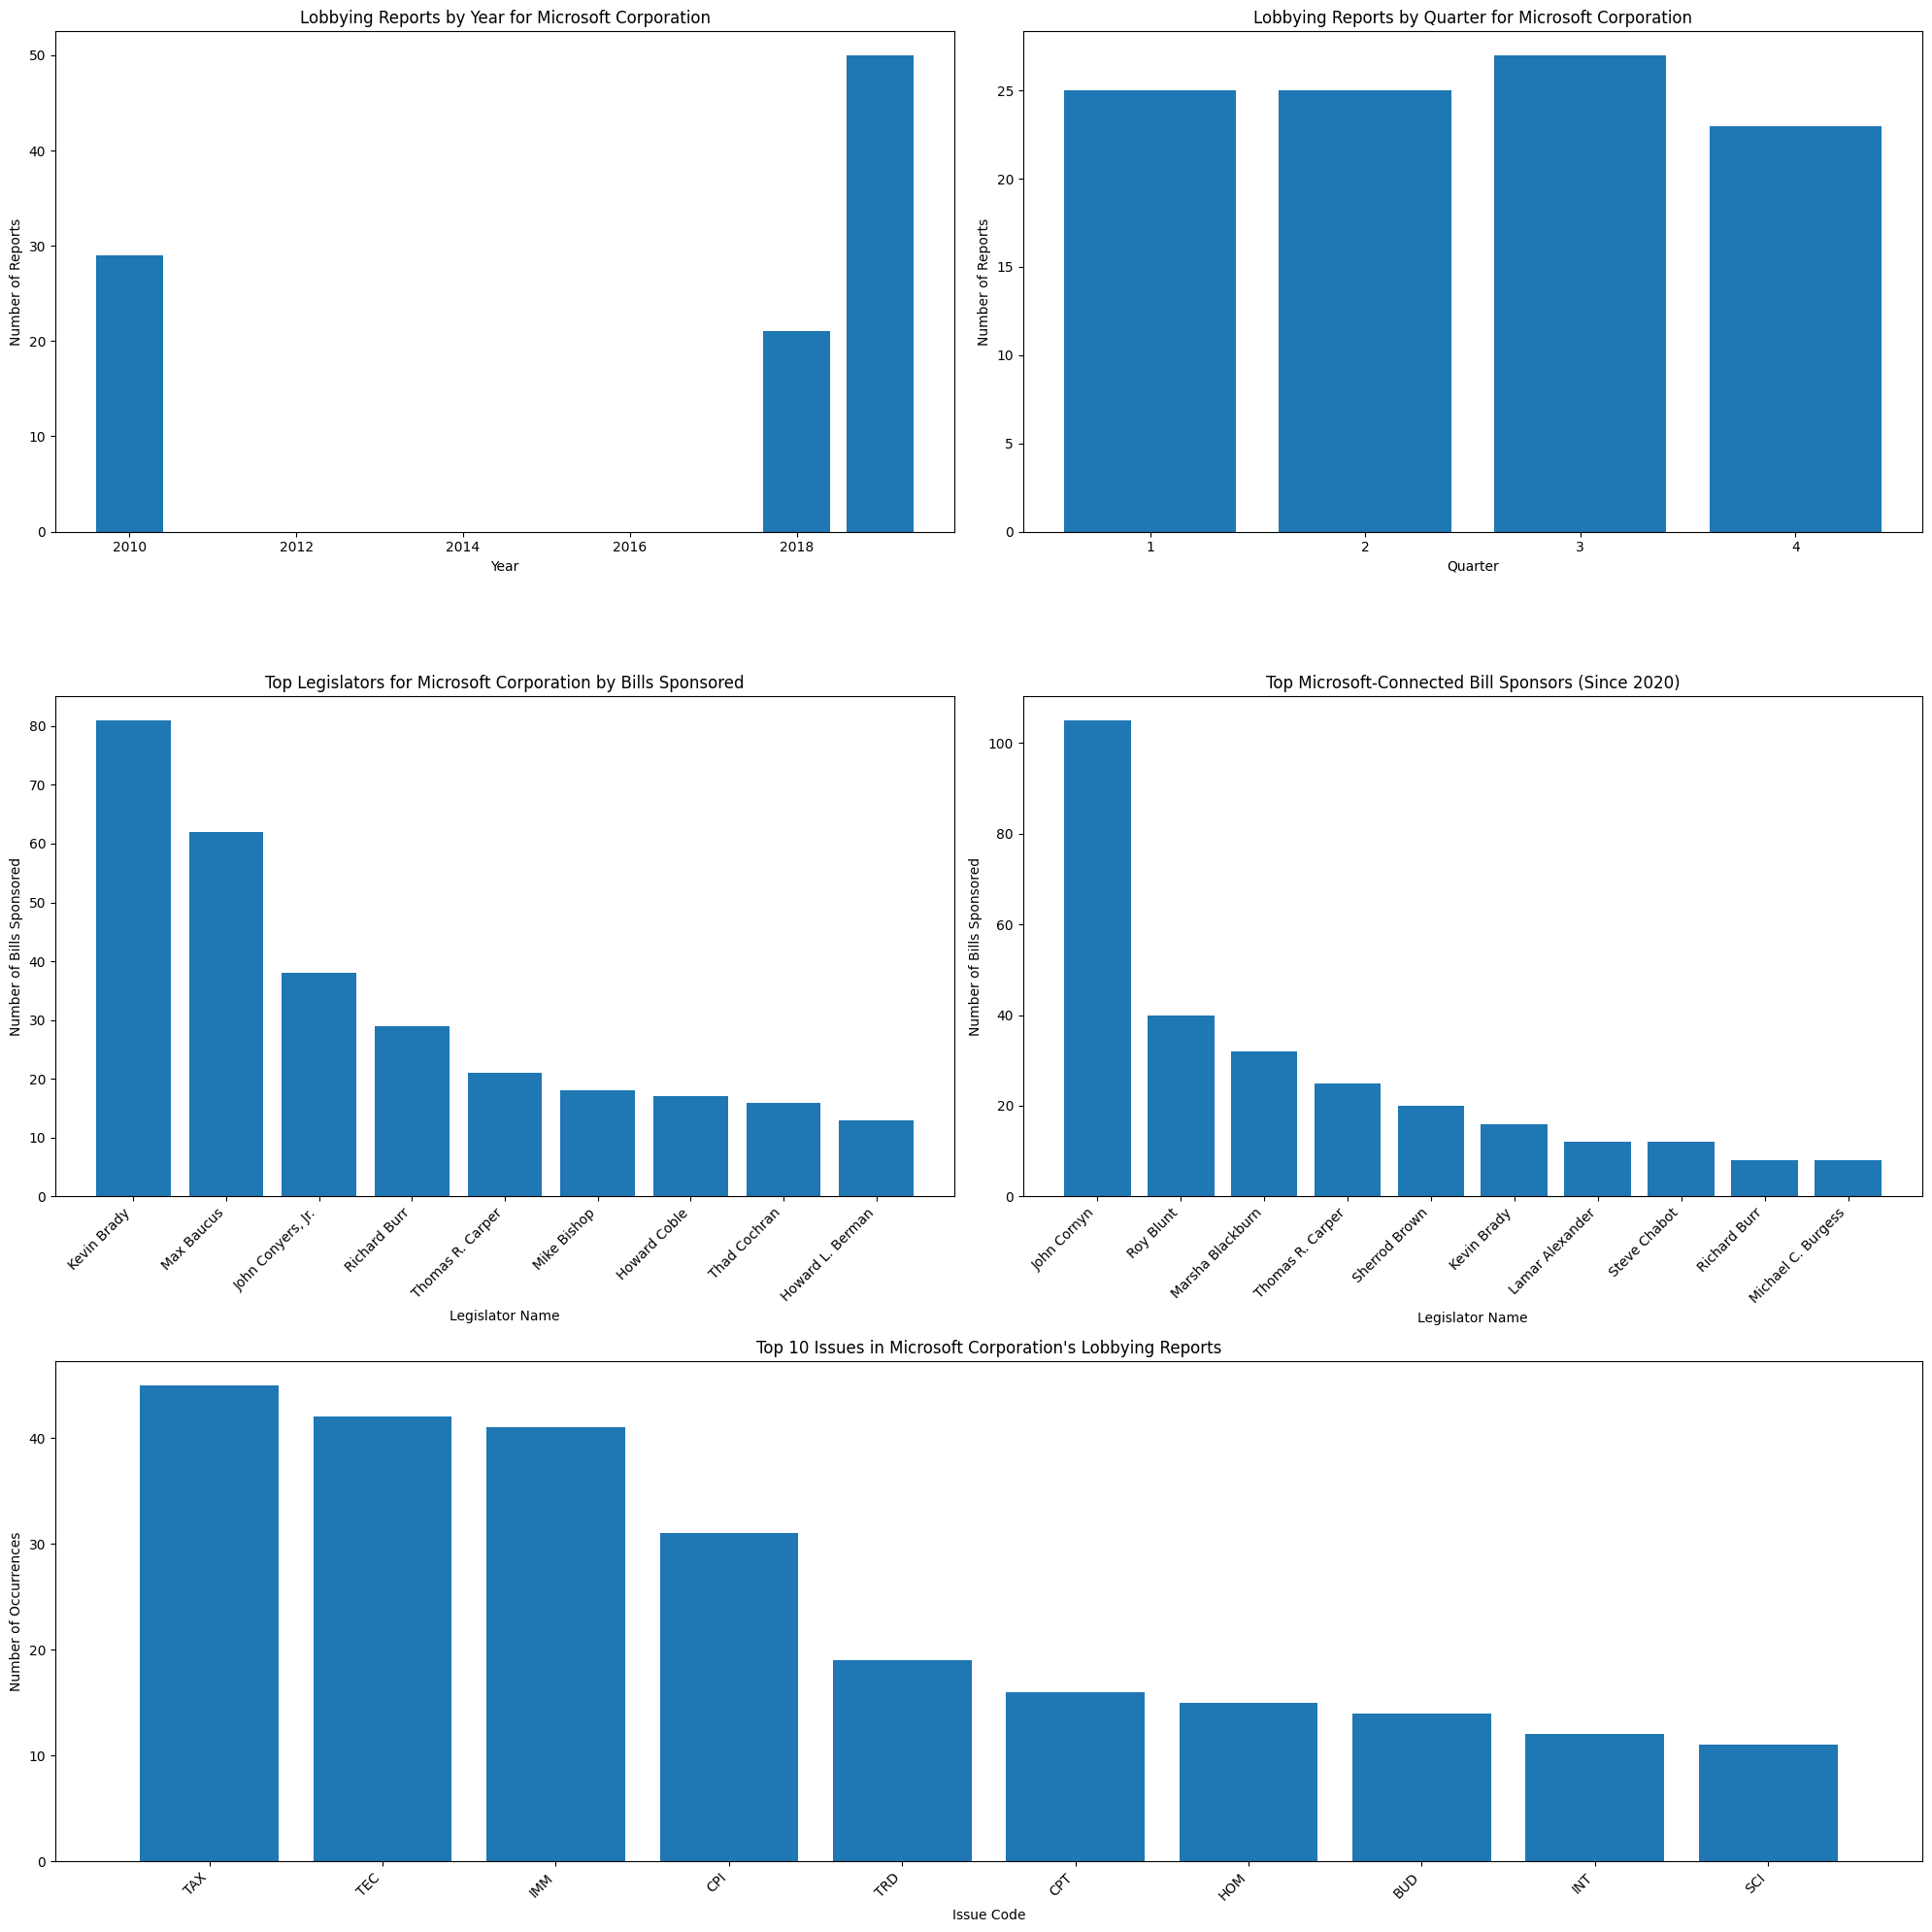

In [42]:
# Create visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.figure(figsize=(20, 20))
gs = GridSpec(3, 2, figure=plt.gcf())

# 1. Reports by Year
ax1 = plt.subplot(gs[0, 0])
years, counts = zip(*sorted(report_years.items()))
ax1.bar(years, counts)
ax1.set_title(f"Lobbying Reports by Year for {CLIENT_NAME}")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Reports")

# 2. Reports by Quarter
ax2 = plt.subplot(gs[0, 1])
quarters, counts = zip(*sorted(report_quarters.items()))
ax2.bar(quarters, counts)
ax2.set_title(f"Lobbying Reports by Quarter for {CLIENT_NAME}")
ax2.set_xlabel("Quarter")
ax2.set_ylabel("Number of Reports")

# 3. Top Legislators by Bills Sponsored
ax3 = plt.subplot(gs[1, 0])
top_legislators = dict(legislator_counter.most_common(10))
legislator_names = []
legislator_values = []
for leg_id, value in top_legislators.items():
    name = get_legislator_name(leg_id)
    if name:
        legislator_names.append(name)
        legislator_values.append(value)
    else:
        print(f"Warning: No name found for legislator ID {leg_id}")

ax3.bar(legislator_names, legislator_values)
ax3.set_title(f"Top Legislators for {CLIENT_NAME} by Bills Sponsored")
ax3.set_xlabel("Legislator Name")
ax3.set_ylabel("Number of Bills Sponsored")
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha="right")

# 4. Top Bill Sponsors (Recent Bills)
if recent_ms_bills:  # Only create this plot if we have data
    ax4 = plt.subplot(gs[1, 1])
    top_sponsors = dict(bill_sponsors.most_common(10))
    sponsor_names = []
    sponsor_values = []
    for leg_id, value in top_sponsors.items():
        name = get_legislator_name(leg_id)
        if name:
            sponsor_names.append(name)
            sponsor_values.append(value)
        else:
            print(f"Warning: No name found for legislator ID {leg_id}")

    if sponsor_names:  # Only plot if we have names
        ax4.bar(sponsor_names, sponsor_values)
        ax4.set_title("Top Microsoft-Connected Bill Sponsors (Since 2020)")
        ax4.set_xlabel("Legislator Name")
        ax4.set_ylabel("Number of Bills Sponsored")
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha="right")

# Add issues plot
ax5 = plt.subplot(gs[2, :])  # Use entire bottom row
top_issues = dict(issue_codes.most_common(10))
ax5.bar(top_issues.keys(), top_issues.values())
ax5.set_title(f"Top 10 Issues in {CLIENT_NAME}'s Lobbying Reports")
ax5.set_xlabel("Issue Code")
ax5.set_ylabel("Number of Occurrences")
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()
plt.close()

## Strategic Insights

Finally, we'll summarize key findings that could inform future lobbying strategy. These insights combine various aspects of our analysis to provide actionable intelligence for corporate decision-makers.

In [40]:
# Corporate Strategy Insights
print("\nKey Insights for Corporate Lobbying Strategy:")
print(f"1. {CLIENT_NAME} has been involved in {len(client_reports.data)} lobbying reports.")
print(f"2. The company has {len(network_data.data)} network connections with legislators.")
most_active_year = report_years.most_common(1)[0][0]
print(f"3. The most active year for lobbying was {most_active_year} with {report_years[most_active_year]} reports.")
most_active_quarter = report_quarters.most_common(1)[0][0]
print(f"4. The most active quarter for lobbying is Q{most_active_quarter} with {report_quarters[most_active_quarter]} reports.")
if legislator_counter:
    top_legislator_id = legislator_counter.most_common(1)[0][0]
    top_legislator_name = get_legislator_name(top_legislator_id)
    print(f"5. The legislator most frequently connected to {CLIENT_NAME}'s lobbying efforts is {top_legislator_name}, with {legislator_counter[top_legislator_id]} bills sponsored.")
if recent_ms_bills:
    print(f"6. Since 2020, {len(recent_ms_bills)} bills have been introduced by legislators connected to {CLIENT_NAME}'s lobbying network.")
else:
    print(f"6. No recent bills found for legislators connected to {CLIENT_NAME}'s lobbying network.")
if issue_codes:
    print("7. The company's most frequent lobbying issues are:")
    for code, count in issue_codes.most_common(3):
        description = issue_text_cache.get(code, "No description available")
        print(f"   - {code} ({count} occurrences): {description[:100]}...")
else:
    print("7. No lobbying issues found in the available data.")


Key Insights for Corporate Lobbying Strategy:
1. Microsoft Corporation has been involved in 100 lobbying reports.
2. The company has 100 network connections with legislators.
3. The most active year for lobbying was 2019 with 50 reports.
4. The most active quarter for lobbying is Q3 with 27 reports.
5. The legislator most frequently connected to Microsoft Corporation's lobbying efforts is Kevin Brady, with 81 bills sponsored.
6. Since 2020, 311 bills have been introduced by legislators connected to Microsoft Corporation's lobbying network.
7. The company's most frequent lobbying issues are:
   - TAX (45 occurrences): Tax extenders...
   - TEC (42 occurrences): telecommuications reform; online advertising; white spaces; online competitiveness, privacy...
   - IMM (41 occurrences): immigration issues...
